# Intel Image Classification
### Deep Learning Course - Excercise 4
---
* **Student Name:** Daniela Slavutin
* **Date:** December 2025
* **Dataset:** [Intel Image Classification] (https://www.kaggle.com/datasets/puneet6060/intel-image-classification)
---

In [1]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from fontTools.misc.cython import returns
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
# This code sets up libraries for working with CNNs, datasets, and visualization.

## Preparing the Datasets

Here we used simple transformations before going to the training phase, such as resizing, converting to tensors and normalizing.

## Data Loading Strategy

We used the `torchvision.dataset.ImageFolder` class to make the data loading process much easier. Since the Intel Image dataset is organized in a standard hierarchical structure, `ImageFolder` allows us to:
1. **Automate Labeling:** Automatically infer class labels based on the folder names.
2. **Apply Transformations:** Seamlessly integrate the preprocessing and augmentation pipeline.

In [2]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
from torchvision.datasets import ImageFolder

train_dataset = ImageFolder(root="intel_image_dataset/seg_train", transform=transform)
test_dataset = ImageFolder(root="intel_image_dataset/seg_test", transform=transform)

# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

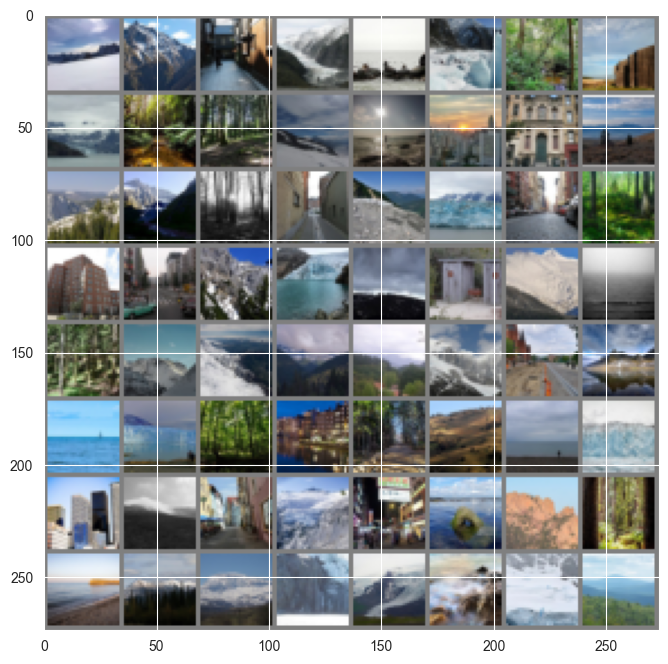

Labels: tensor([2, 2, 5, 2])


In [4]:
# Helper function to display images
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(8, 8))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))
print("Labels:", labels[:4])

## Model Architecture & Complexity Analysis

Using the template given in the `Practice CNN` notebook to custom the CNN needed for Intel Images dataset.

### Architecture Details:
The model has two main stages:
1. **Feature Extraction:**
   * **Two Convolutional Blocks:** We use two `Conv2d` layers (32 and 64 filters) to capture spatial features from the images.
   * **MaxPooling:** Each Convolution is followed by `MaxPool2d` to reduce spatial dimensions and computation.
2. **Classification (Fully Connected):**
   * **Flattening:** Converting the 2D Feature maps into a 1D vector.
   * **Dropout (0.3):** We incorporated a `Dropout` layer with probability of $p=0.3$. This randomly zeros out 30% of the neurons during training to prevent overfitting.
   * **Linear Layers:** Two fully connected layers map the features to the final 6 class scores.

In [5]:
class IntelImgCNN(nn.Module):
    def __init__(self, dropout=0.3):
        super(IntelImgCNN, self).__init__()
        # convolutional blocks
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
       x = self.pool(torch.relu(self.conv1(x)))
       x = self.pool(torch.relu(self.conv2(x)))
       x = x.view(-1, 64 * 8 * 8) # Flatten
       x = self.dropout(x) # Applying dropout
       x = torch.relu(self.fc1(x))
       x = self.fc2(x)
       return x

## Parameter Calculation

To understand the model's complexity and memory requirements, we manually calculated the total number of trainable parameters (Weights + Biases) for each layer below:

PSA: The calculations are brought here from the `Practice CNN` notebook

In [6]:

    # Conv1 (First Convolutional Layer)
conv1_output_channels = 32  # Number of output channels
conv1_input_channels = 3    # Number of input channels (RGB image)
conv1_kernel_size = 3       # Kernel size is 3x3
conv1_biases = conv1_output_channels  # One bias per output channel

# Formula: (Output Channels x Input Channels x Kernel Height x Kernel Width) + Biases
conv1_weights = conv1_output_channels * conv1_input_channels * conv1_kernel_size * conv1_kernel_size
conv1_total_weights = conv1_weights + conv1_biases  # Total weights for Conv1

# Conv2 (Second Convolutional Layer)
conv2_output_channels = 64  # Number of output channels
conv2_input_channels = 32   # Number of input channels (from Conv1 output)
conv2_kernel_size = 3       # Kernel size is 3x3
conv2_biases = conv2_output_channels  # One bias per output channel

# Formula: (Output Channels x Input Channels x Kernel Height x Kernel Width) + Biases
conv2_weights = conv2_output_channels * conv2_input_channels * conv2_kernel_size * conv2_kernel_size
conv2_total_weights = conv2_weights + conv2_biases  # Total weights for Conv2

# FC1 (First Fully Connected Layer)
fc1_input_neurons = 64 * 8 * 8  # Input neurons (from Conv2 output size)
fc1_output_neurons = 512        # Number of output neurons
fc1_biases = fc1_output_neurons # One bias per output neuron

# Formula: (Output Neurons x Input Neurons) + Biases
fc1_weights = fc1_output_neurons * fc1_input_neurons
fc1_total_weights = fc1_weights + fc1_biases  # Total weights for FC1

# FC2 (Second Fully Connected Layer)
fc2_input_neurons = 512   # Input neurons (from FC1 output)
fc2_output_neurons = 6  # Since Intel Image has 6 classes
fc2_biases = fc2_output_neurons  # One bias per output neuron

# Formula: (Output Neurons x Input Neurons) + Biases
fc2_weights = fc2_output_neurons * fc2_input_neurons
fc2_total_weights = fc2_weights + fc2_biases  # Total weights for FC2

# Total Weights for the Entire Network
total_weights = conv1_total_weights + conv2_total_weights + fc1_total_weights + fc2_total_weights

# Results
weights = {
    "Conv1 Weights": conv1_total_weights,
    "Conv2 Weights": conv2_total_weights,
    "FC1 Weights": fc1_total_weights,
    "FC2 Weights": fc2_total_weights,
    "Total Weights": total_weights
}
print(f"Weights: {weights}")

Weights: {'Conv1 Weights': 896, 'Conv2 Weights': 18496, 'FC1 Weights': 2097664, 'FC2 Weights': 3078, 'Total Weights': 2120134}


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = IntelImgCNN().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [8]:
def accuracy(output, labels):
    _, preds = torch.max(output, 1)
    return torch.sum(preds == labels).item() / labels.size(0)

def save_model(path="intel_img_cnn.pth"):
    torch.save(model.state_dict(), path)

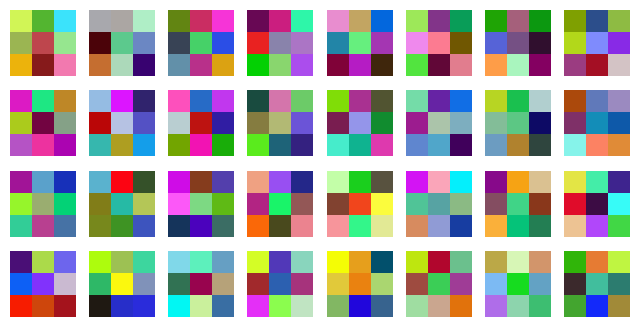

In [9]:
def visualize_filters(layer):
    filters = layer.weight.data.clone()
    filters = filters - filters.min()
    filters = filters / filters.max()
    filter_num = filters.shape[0]
    n_columns = 8
    n_rows = filter_num // n_columns + (filter_num % n_columns > 0)
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(n_columns, n_rows))
    for i in range(filter_num):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(filters[i].permute(1, 2, 0))
        axs[row, col].axis('off')
    plt.show()

# Visualize the filters of the first convolutional layer
model = IntelImgCNN()
visualize_filters(model.conv1)

## Training Configuration

We use the following hyperparameters for the training process:
| Hyperparameter | Value | Description |
| :--- | :--- | :--- |
| **Model Archotecture** | CNN (Customized) | 2 Conv Layers + Dropout (0.3)|
| **Optimizer** | Adam | Adaptive Moment Estimation |
| **Loss Function** | CrossEntropyLoss | Standard for multi-class classification|
| **Learning Rate** | 0.001 | Initial learning rate|
| **Batch Size** | 32 | Number of images per step |
| **Scheduler** | ReduceROnPlateau | Decays LR if validation loss stalls (patience=3) |

Epoch 3/12, Train Loss: 1.3404, Val Loss: 1.1579
Epoch 5/12, Train Loss: 1.2418, Val Loss: 1.0720
Epoch 7/12, Train Loss: 1.2049, Val Loss: 1.0964
Epoch 9/12, Train Loss: 1.1773, Val Loss: 1.0317
Epoch 11/12, Train Loss: 1.1720, Val Loss: 1.0405
Epoch 13/12, Train Loss: 1.1399, Val Loss: 1.0268


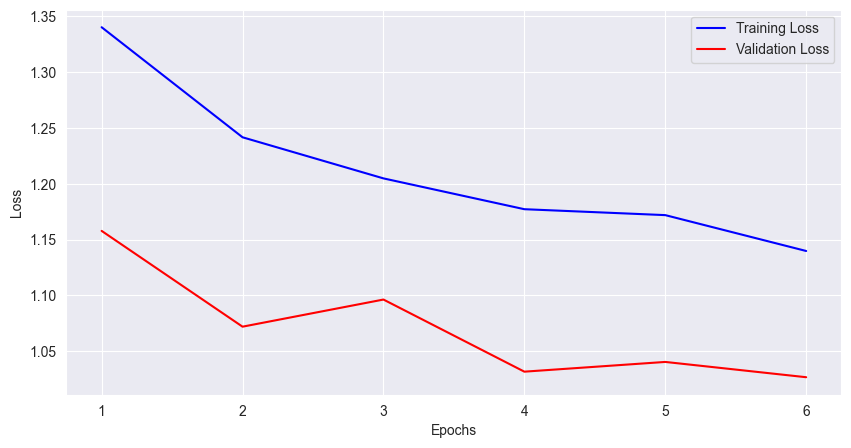

In [10]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Initialize the model, loss function, and optimizer
model = IntelImgCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# Training loop
num_epochs = 12
train_losses = []
val_losses = []

train_dataset.transform = transform_train

for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase
    if epoch%2 == 0:
      train_loss = running_loss/len(train_loader)
      train_losses.append(train_loss)
      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in test_loader:
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
      val_loss = val_loss/len(test_loader)
      val_losses.append(val_loss)
      scheduler.step(val_loss)

      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10,5))
plt.plot(range(1, int(num_epochs/2)+1), train_losses, color='blue',label='Training Loss')
plt.plot(range(1, int(num_epochs/2)+1), val_losses, color='red',label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

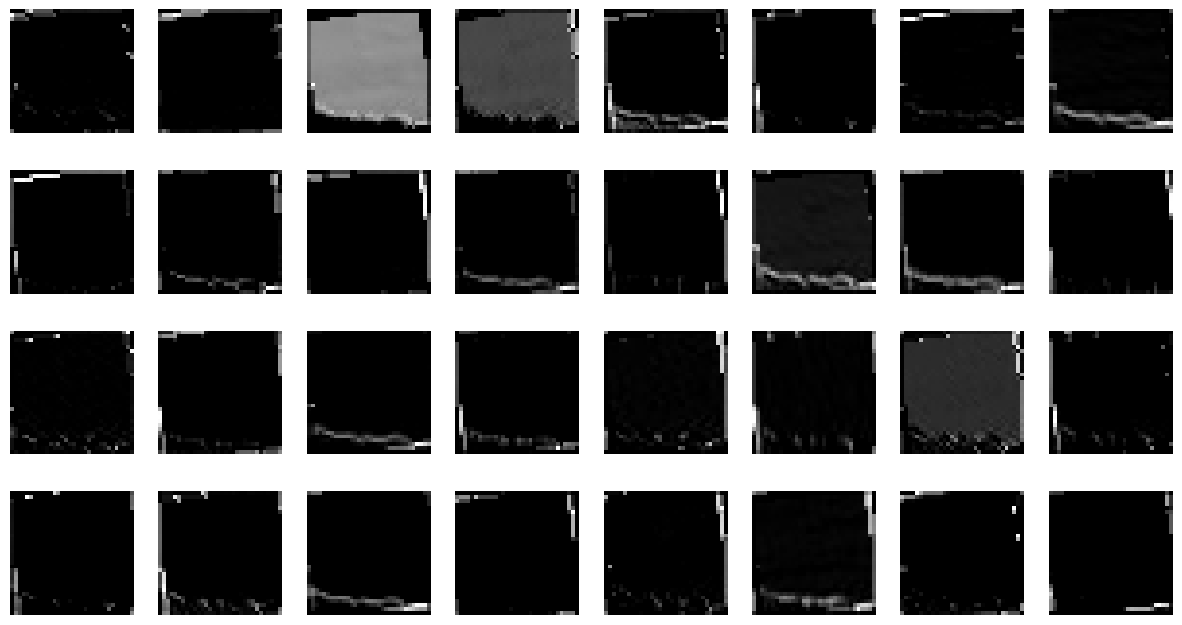

In [11]:
def visualize_feature_maps(image, model):
    x = image.unsqueeze(0)
    x = model.conv1(x)
    x = torch.relu(x)
    feature_maps = x.detach().squeeze(0)
    num_maps = feature_maps.shape[0]
    n_columns = 8
    n_rows = num_maps // n_columns + (num_maps % n_columns > 0)
    fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
    for i in range(num_maps):
        row = i // n_columns
        col = i % n_columns
        axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')
        axs[row, col].axis('off')
    plt.show()

# Visualize feature maps for a single image
sample_image, _ = train_dataset[0]
visualize_feature_maps(sample_image, model)

In [12]:
# Test the model
correct = 0
total = 0
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 59.63%


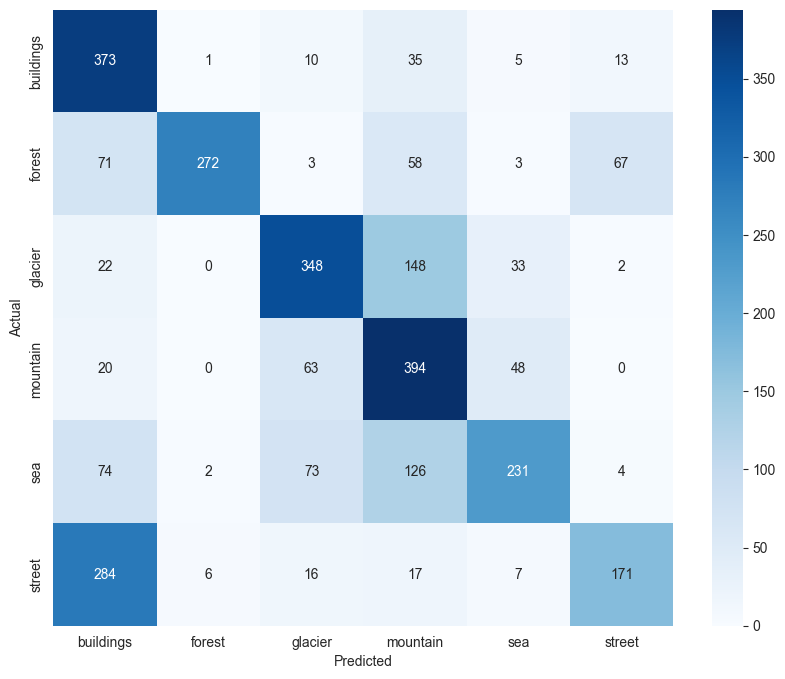

In [13]:
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

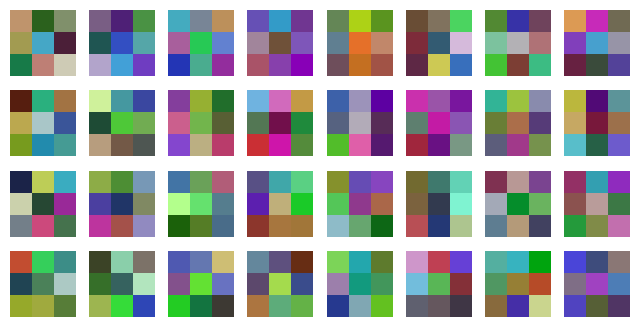

In [14]:
# Visualize the filters of the first convolutional layer after training
visualize_filters(model.conv1)

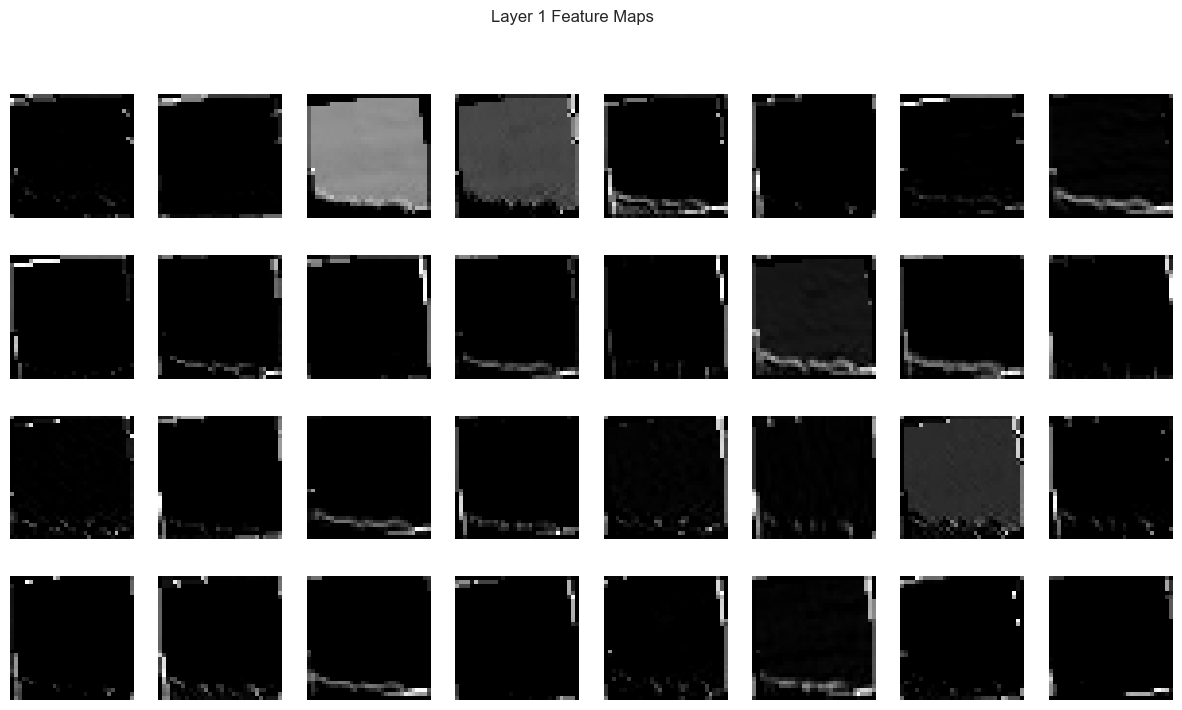

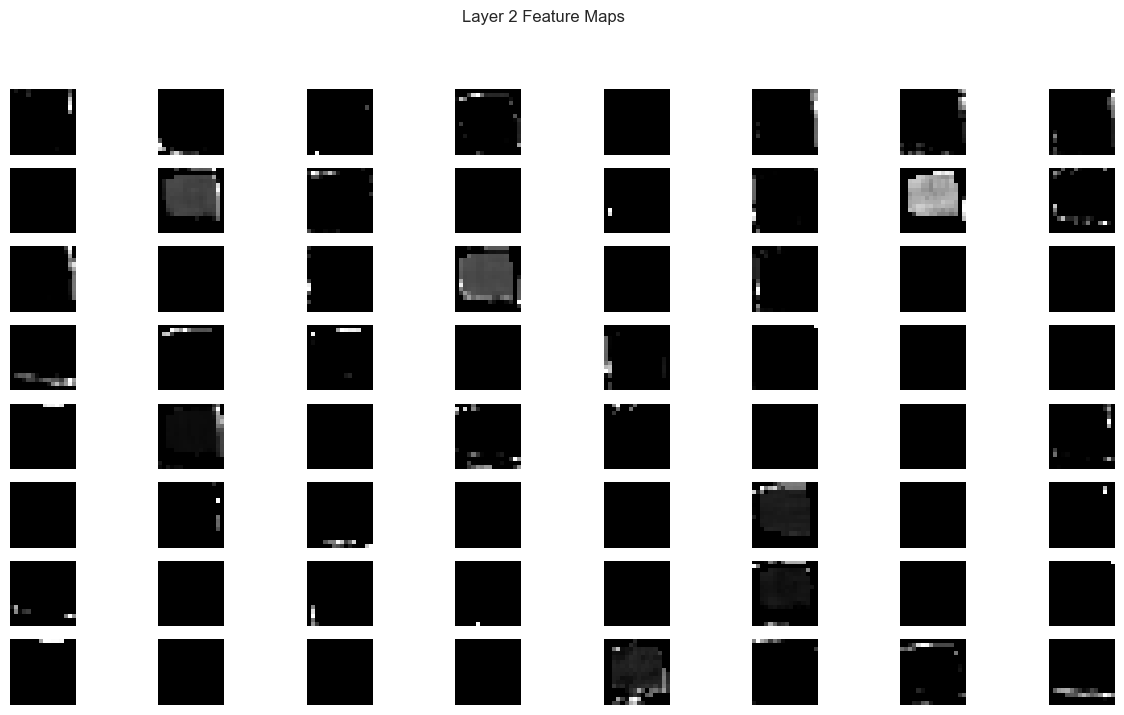

In [15]:
def visualize_intermediate_layers(image, model):
    activations = []
    x = image.unsqueeze(0)
    x = model.conv1(x)
    x = torch.relu(x)
    activations.append(x)
    x = model.pool(x)
    x = model.conv2(x)
    x = torch.relu(x)
    activations.append(x)
    x = model.pool(x)

    for idx, activation in enumerate(activations):
        feature_maps = activation.detach().squeeze(0)
        num_maps = feature_maps.shape[0]
        n_columns = 8
        n_rows = num_maps // n_columns + (num_maps % n_columns > 0)
        fig, axs = plt.subplots(n_rows, n_columns, figsize=(15, 8))
        fig.suptitle(f'Layer {idx+1} Feature Maps')
        for i in range(min(num_maps, n_columns * n_rows)):
            row = i // n_columns
            col = i % n_columns
            axs[row, col].imshow(feature_maps[i].numpy(), cmap='gray')
            axs[row, col].axis('off')
        plt.show()

# Visualize feature maps at different layers
visualize_intermediate_layers(sample_image, model)

## Experiment No.2 - Decreasing Batch Size

In order to understand the impact of applying different values for our hyperparameters on our CNN's performance we decided to decrease the batch size from 64 to 32

### Hypothesis

Reducing the batch size increases the frequency of weight updates per each epoch. We hypothesize that more frequent updates will allow the model to learn features more precisely and adjust to the data nuances faster

> **Study Plan Analogy**
>
> Batches for a CNN model are just like a student's studying plan for an exam:
> * **Batch 64:** A student reads 64 pages before stopping for revision. They cover the ground quickly, but might miss small details or drift off track before getting feedback.
> * **Batch 32:** A student reads 32 pages before stopping for revision. They may cover the ground much slower but they receive feedback twice as often, allowing them to catch small nuances more effectively.

Epoch 3/12, Train Loss: 1.3225, Val Loss: 1.1275
Epoch 5/12, Train Loss: 1.2355, Val Loss: 1.0993
Epoch 7/12, Train Loss: 1.2003, Val Loss: 1.1119
Epoch 9/12, Train Loss: 1.1710, Val Loss: 1.0513
Epoch 11/12, Train Loss: 1.1486, Val Loss: 0.9846
Epoch 13/12, Train Loss: 1.1421, Val Loss: 0.9897


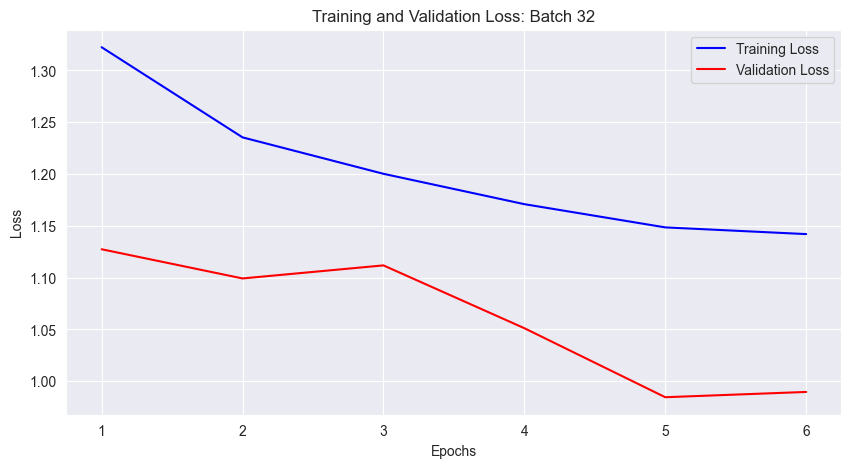

In [16]:
# Decreasing the size of the batch
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Going through the training loops over again
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32,4),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


# Initialize the model, loss function, and optimizer
model = IntelImgCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

# Training loop
num_epochs = 12
train_losses = []
val_losses = []

train_dataset.transform = transform_train

for epoch in range(1, num_epochs+1):

    running_loss = 0.0
    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validation phase
    if epoch%2 == 0:
      train_loss = running_loss/len(train_loader)
      train_losses.append(train_loss)
      model.eval()
      val_loss = 0.0
      with torch.no_grad():
          for inputs, labels in test_loader:
              outputs = model(inputs)
              loss = criterion(outputs, labels)
              val_loss += loss.item()
      val_loss = val_loss/len(test_loader)
      val_losses.append(val_loss)
      scheduler.step(val_loss)

      print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

# Plotting training and validation loss
plt.figure(figsize=(10,5))
plt.plot(range(1, int(num_epochs/2)+1), train_losses, color='blue',label='Training Loss')
plt.plot(range(1, int(num_epochs/2)+1), val_losses, color='red',label='Validation Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation Loss: Batch 32')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Test the model
model.eval()
all_preds = []
all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 62.20%


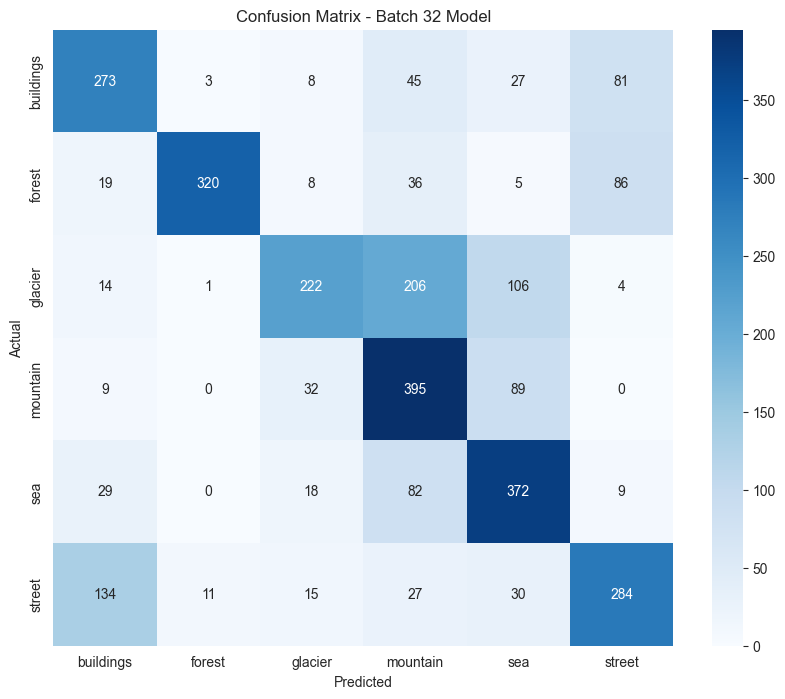

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Batch 32 Model')
plt.show()

## Experiment No.3 - Replacing optimizers: Adam vs. SGD

Here we compared two popular optimization algorithms to see which one converges faster and yields better stability for our dataset:
1. **Adam (Adaptive Moment Estimation):** Our baseline optimizer. It adapts the learning rate for each parameter individualy.
2. **SGD (Stochastic Gradient Decent):**  A classic optimizer, used here with momentum of 0.9.

### Hypothesis
We have two hypothesizes:
1. **Convergence Speed:** Adam will show a significantly faster drop in training loss during the initial epochs due to its adaptive learning rate mechanism.
2. **Generalization:** SGD with momentum is expected to learn more slowly. While literature suggets SGD often achieves better long-term generalization, given our limited number of epochs (12), Adam is like to outperform SGD in both speed and accuracy within this timeframe.

Training with SGD Optimizer...
Epoch 3/12, SGD Train Loss: 1.5244, SGD Val Loss: 1.5188
Epoch 5/12, SGD Train Loss: 1.4246, SGD Val Loss: 1.2868
Epoch 7/12, SGD Train Loss: 1.3616, SGD Val Loss: 1.2570
Epoch 9/12, SGD Train Loss: 1.3173, SGD Val Loss: 1.1995
Epoch 11/12, SGD Train Loss: 1.2900, SGD Val Loss: 1.1546
Epoch 13/12, SGD Train Loss: 1.2708, SGD Val Loss: 1.1864


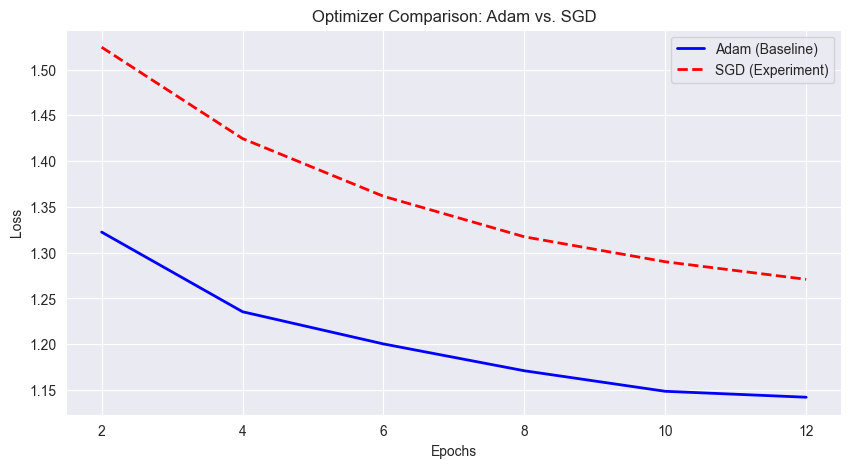

In [19]:
model_sgd = IntelImgCNN().to(device)

optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=0.001, momentum=0.9)
criterion_sgd = nn.CrossEntropyLoss()

sgd_train_losses = []
sgd_val_losses = []

print ("Training with SGD Optimizer...")

for epoch in range(1, num_epochs+1):
    running_loss = 0.0
    model_sgd.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer_sgd.zero_grad()
        outputs = model_sgd(inputs)
        loss = criterion_sgd(outputs, labels)
        loss.backward()
        optimizer_sgd.step()
        running_loss += loss.item()

    if epoch%2 == 0:
        avg_train_loss = running_loss/len(train_loader)
        sgd_train_losses.append(avg_train_loss)

        model_sgd.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in test_loader:
                outputs = model_sgd(inputs)
                loss = criterion_sgd(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss/len(test_loader)
        sgd_val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, SGD Train Loss: {avg_train_loss:.4f}, SGD Val Loss: {avg_val_loss:.4f}")



plt.figure(figsize=(10,5))
plt.plot(range(2, num_epochs + 1, 2), train_losses, label='Adam (Baseline)', color='blue', linewidth=2)
plt.plot(range(2, num_epochs + 1, 2), sgd_train_losses, label='SGD (Experiment)', color='red', linestyle='--', linewidth=2)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Optimizer Comparison: Adam vs. SGD')
plt.legend()
plt.grid(True)
plt.show()



In [24]:
plt.show()
# Test the model
model_sgd.eval()
sgd_all_preds = []
sgd_all_labels = []
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model_sgd(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        sgd_all_preds.extend(predicted.cpu().numpy())
        sgd_all_labels.extend(labels.cpu().numpy())

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 54.90%


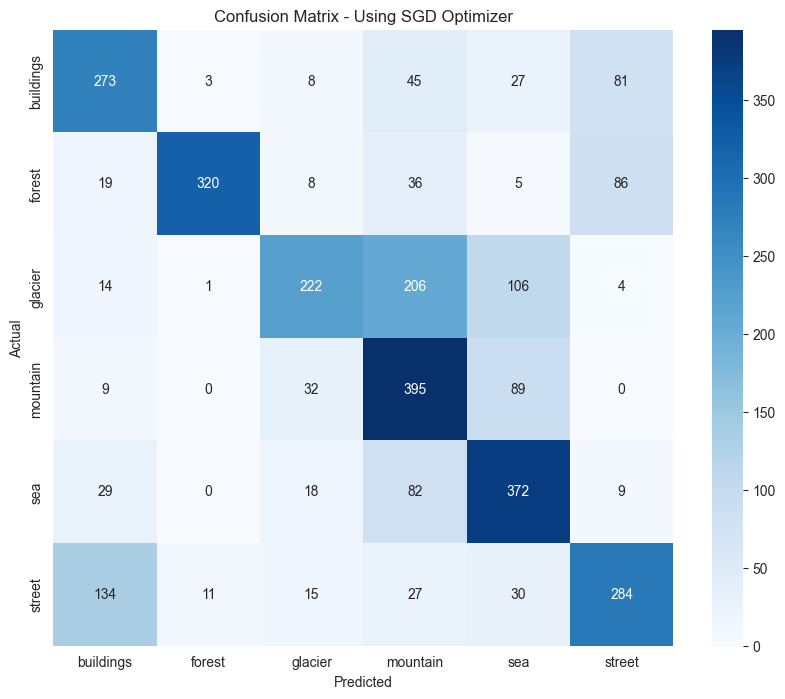

In [21]:
conf_mat = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=train_dataset.classes, yticklabels=train_dataset.classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix - Using SGD Optimizer')
plt.show()

## Most Misclassified Images in the Original Model (LR=0.001, Batch=64, Optimizer=Adam)

Here we can see the most misclassified images by our original model.

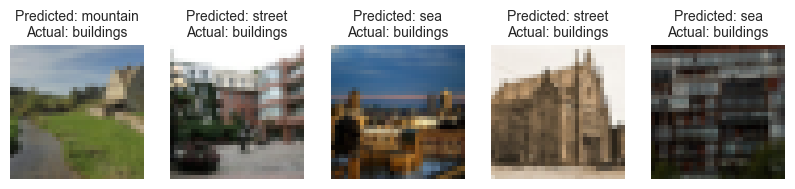

In [22]:
def misclassified_imgs(model, test_loader, device, class_name, num_images=5):
    model.eval()
    imgs_counter = 0
    plt.figure(figsize=(10,6))

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            for j in range(inputs.size(0)):
                if predicted[j] != labels[j]:
                    imgs_counter += 1

                    ax = plt.subplot(1, num_images, imgs_counter)
                    ax.axis('off')
                    ax.set_title(f"Predicted: {class_name[predicted[j]]}\nActual: {class_name[labels[j]]}", fontsize=10)

                    img = inputs[j].cpu().numpy().transpose((1, 2, 0))
                    img = img * 0.5 + 0.5
                    img = np.clip(img, 0, 1)
                    plt.imshow(img)

                    if imgs_counter == num_images:
                        plt.show()
                        return

misclassified_imgs(model, test_loader, device, train_dataset.classes, num_images=5)